# Example of usage Spark OCR for Tables Recognition

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge

Need to specify:
- secret
- license
- aws credentials

In [ ]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../spark-ocr/target/scala-2.12/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
os.environ['SPARK_OCR_LICENSE'] = license
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
imagePath = "./data/tab_images_hocr_1/*.jpg"
imagePath_2 = "./data/tab_images_hocr_2/*.jpg"

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [ ]:
from pyspark.sql import SparkSession
from sparkocr import start
import os

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

## Printed source
### Read images and display it


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


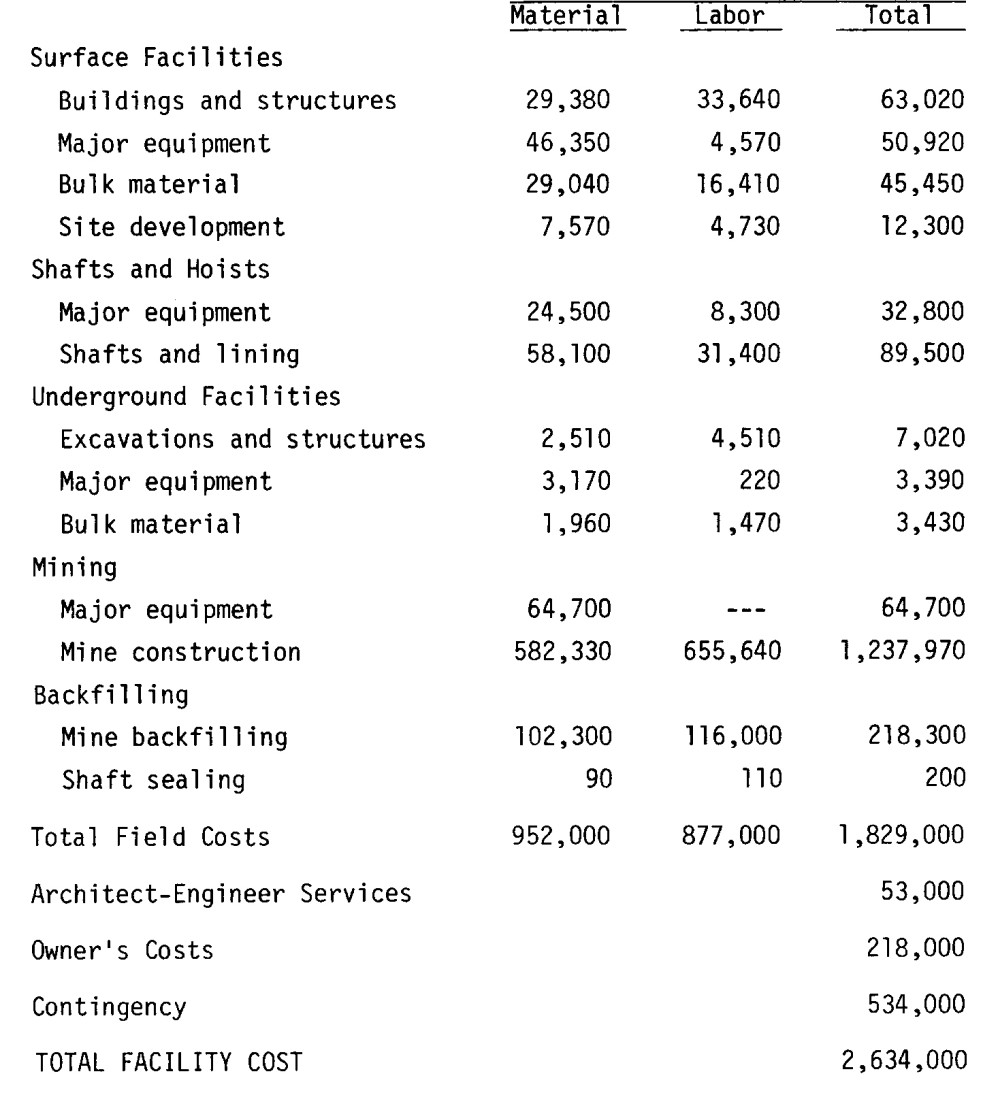

In [ ]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_tables, display_table
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

image_df= spark.read.format("binaryFile").load(imagePath)

display_images(BinaryToImage().transform(image_df), "image")

In [ ]:
binary_to_image = BinaryToImage()

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("table_regions")

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("table_regions") \
    .setOutputCol("table_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_BYTE_GRAY) \
    .setExplodeCols([])

text_detector = ImageTextDetectorV2.pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setWithRefiner(True)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("text_regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green) \
    .setRotated(True)

img_to_hocr = ImageToTextV2().pretrained("ocr_small_printed", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setUsePandasUdf(False) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr") \
    .setGroupImages(False)

hocr_to_table = HocrToTextTable() \
    .setInputCol("hocr") \
    .setRegionCol("table_regions") \
    .setOutputCol("tables")

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr,
    hocr_to_table
])

result = pipeline.transform(image_df).cache()
display(result)

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB
image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
ocr_small_printed download started this may take some time.
Approximate size to download 139.9 MB


+--------------------+--------------------+-------+--------------------+-------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------+-----------+
|         table_image|               image|pagenum|       table_regions|   modificationTime|                path|length|        text_regions|  image_with_regions|                hocr|              tables|exception|table_index|
+--------------------+--------------------+-------+--------------------+-------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------+-----------+
|{file:/home/alexa...|{file:/home/alexa...|      0|{0, 0, 40.0, 0.0,...|2022-12-12 20:17:32|file:/home/alexan...|172124|[{0, 0, 566.32025...|{file:/home/alexa...|<?xml version="1....|{{0, 0, 0.0, 0.0,...|     null|          0|
+--------------------+--------------------+-------+--------------------+-------------------+--------------------+------+--------------------+--------------------+--------------------+--------------------+---------+-----------+

### Show text regions


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 1000 px
    Height: 1095 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


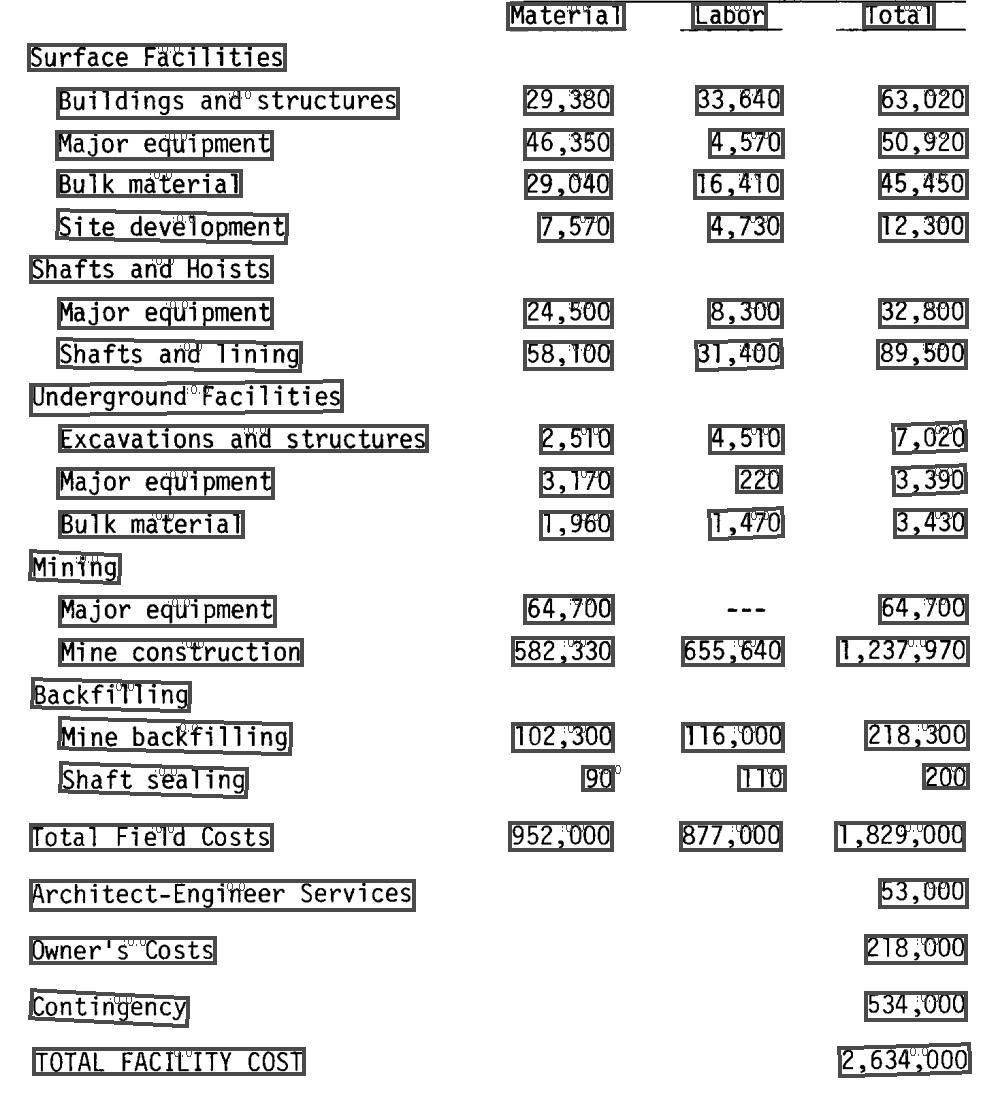

In [ ]:
display_images(result, "image_with_regions")

### Show images with tables


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_1/table4_1.jpg
    Resolution: 0 dpi
    Width: 937 px
    Height: 1093 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


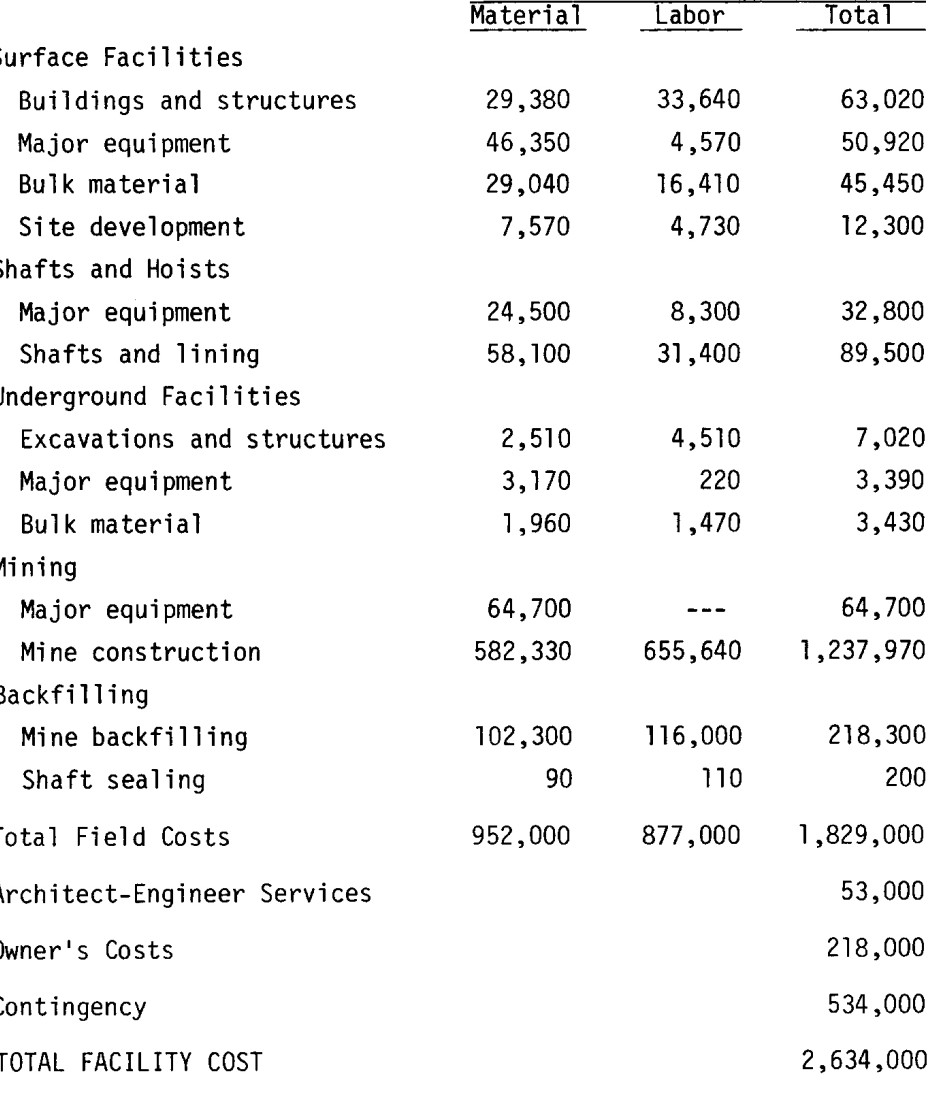

In [ ]:
display_images(result, "table_image")

### Display recognized tables

In [ ]:
display_tables(result, table_col = "tables", table_index_col = "table_index")

Filename: table4_1.jpg
Page:     0
Table:    0
4


col0      col1     col2       col3
0                                MATERIAL    LABOR      TOTAL
1            SURFACE FACILITIES      None     None       None
2      BUILDINGS AND STRUCTURES    29,380   33,640     63,020
3               MAJOR EQUIPMENT    46,350    4,570     50,920
4                 BULK MATERIAL    29,040   16,410     45,450
5              SITE DEVELOPMENT     7,570    4,730     12,300
6             SHAFTS AND HOISTS      None     None       None
7               MAJOR EQUIPMENT    24,500    8,300     32,800
8             SHAFTS AND LINING    58,100   31,400     89,500
9        UNDERGROUND FACILITIES      None     None       None
10   EXCAVATIONS AND STRUCTURES     2,510    4,510      7,020
11              MAJOR EQUIPMENT     3,170      220      3,390
12                BULK MATERIAL     1,960    1,470      3,430
13                       MINING      None     None       None
14              MAJOR EQUIPMENT    64,700              64,700
15            MINE CONSTRUCTION   582,330  655,640  1,237,970
16                  BACKFULLING      None     None       None
17             MINE BACKFILLING   102,300  116,000    218,300
18                SHAFT SEALING        90      710        200
19            TOTAL FIELD COSTS   952.000  877.000  1,829,000
20  ARCHITECT-ENGINEER SERVICES                        53,000
21                OWNER'S COSTS                       218,000
22                  CONTINGENCY                      534.0001

## Handwritten source


    Image #0:
    Origin: file:/home/alexander_jsl/Workspace/spark-ocr-workshop/jupyter/data/tab_images_hocr_2/cTDaR_t00192.jpg
    Resolution: 0 dpi
    Width: 2731 px
    Height: 4096 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


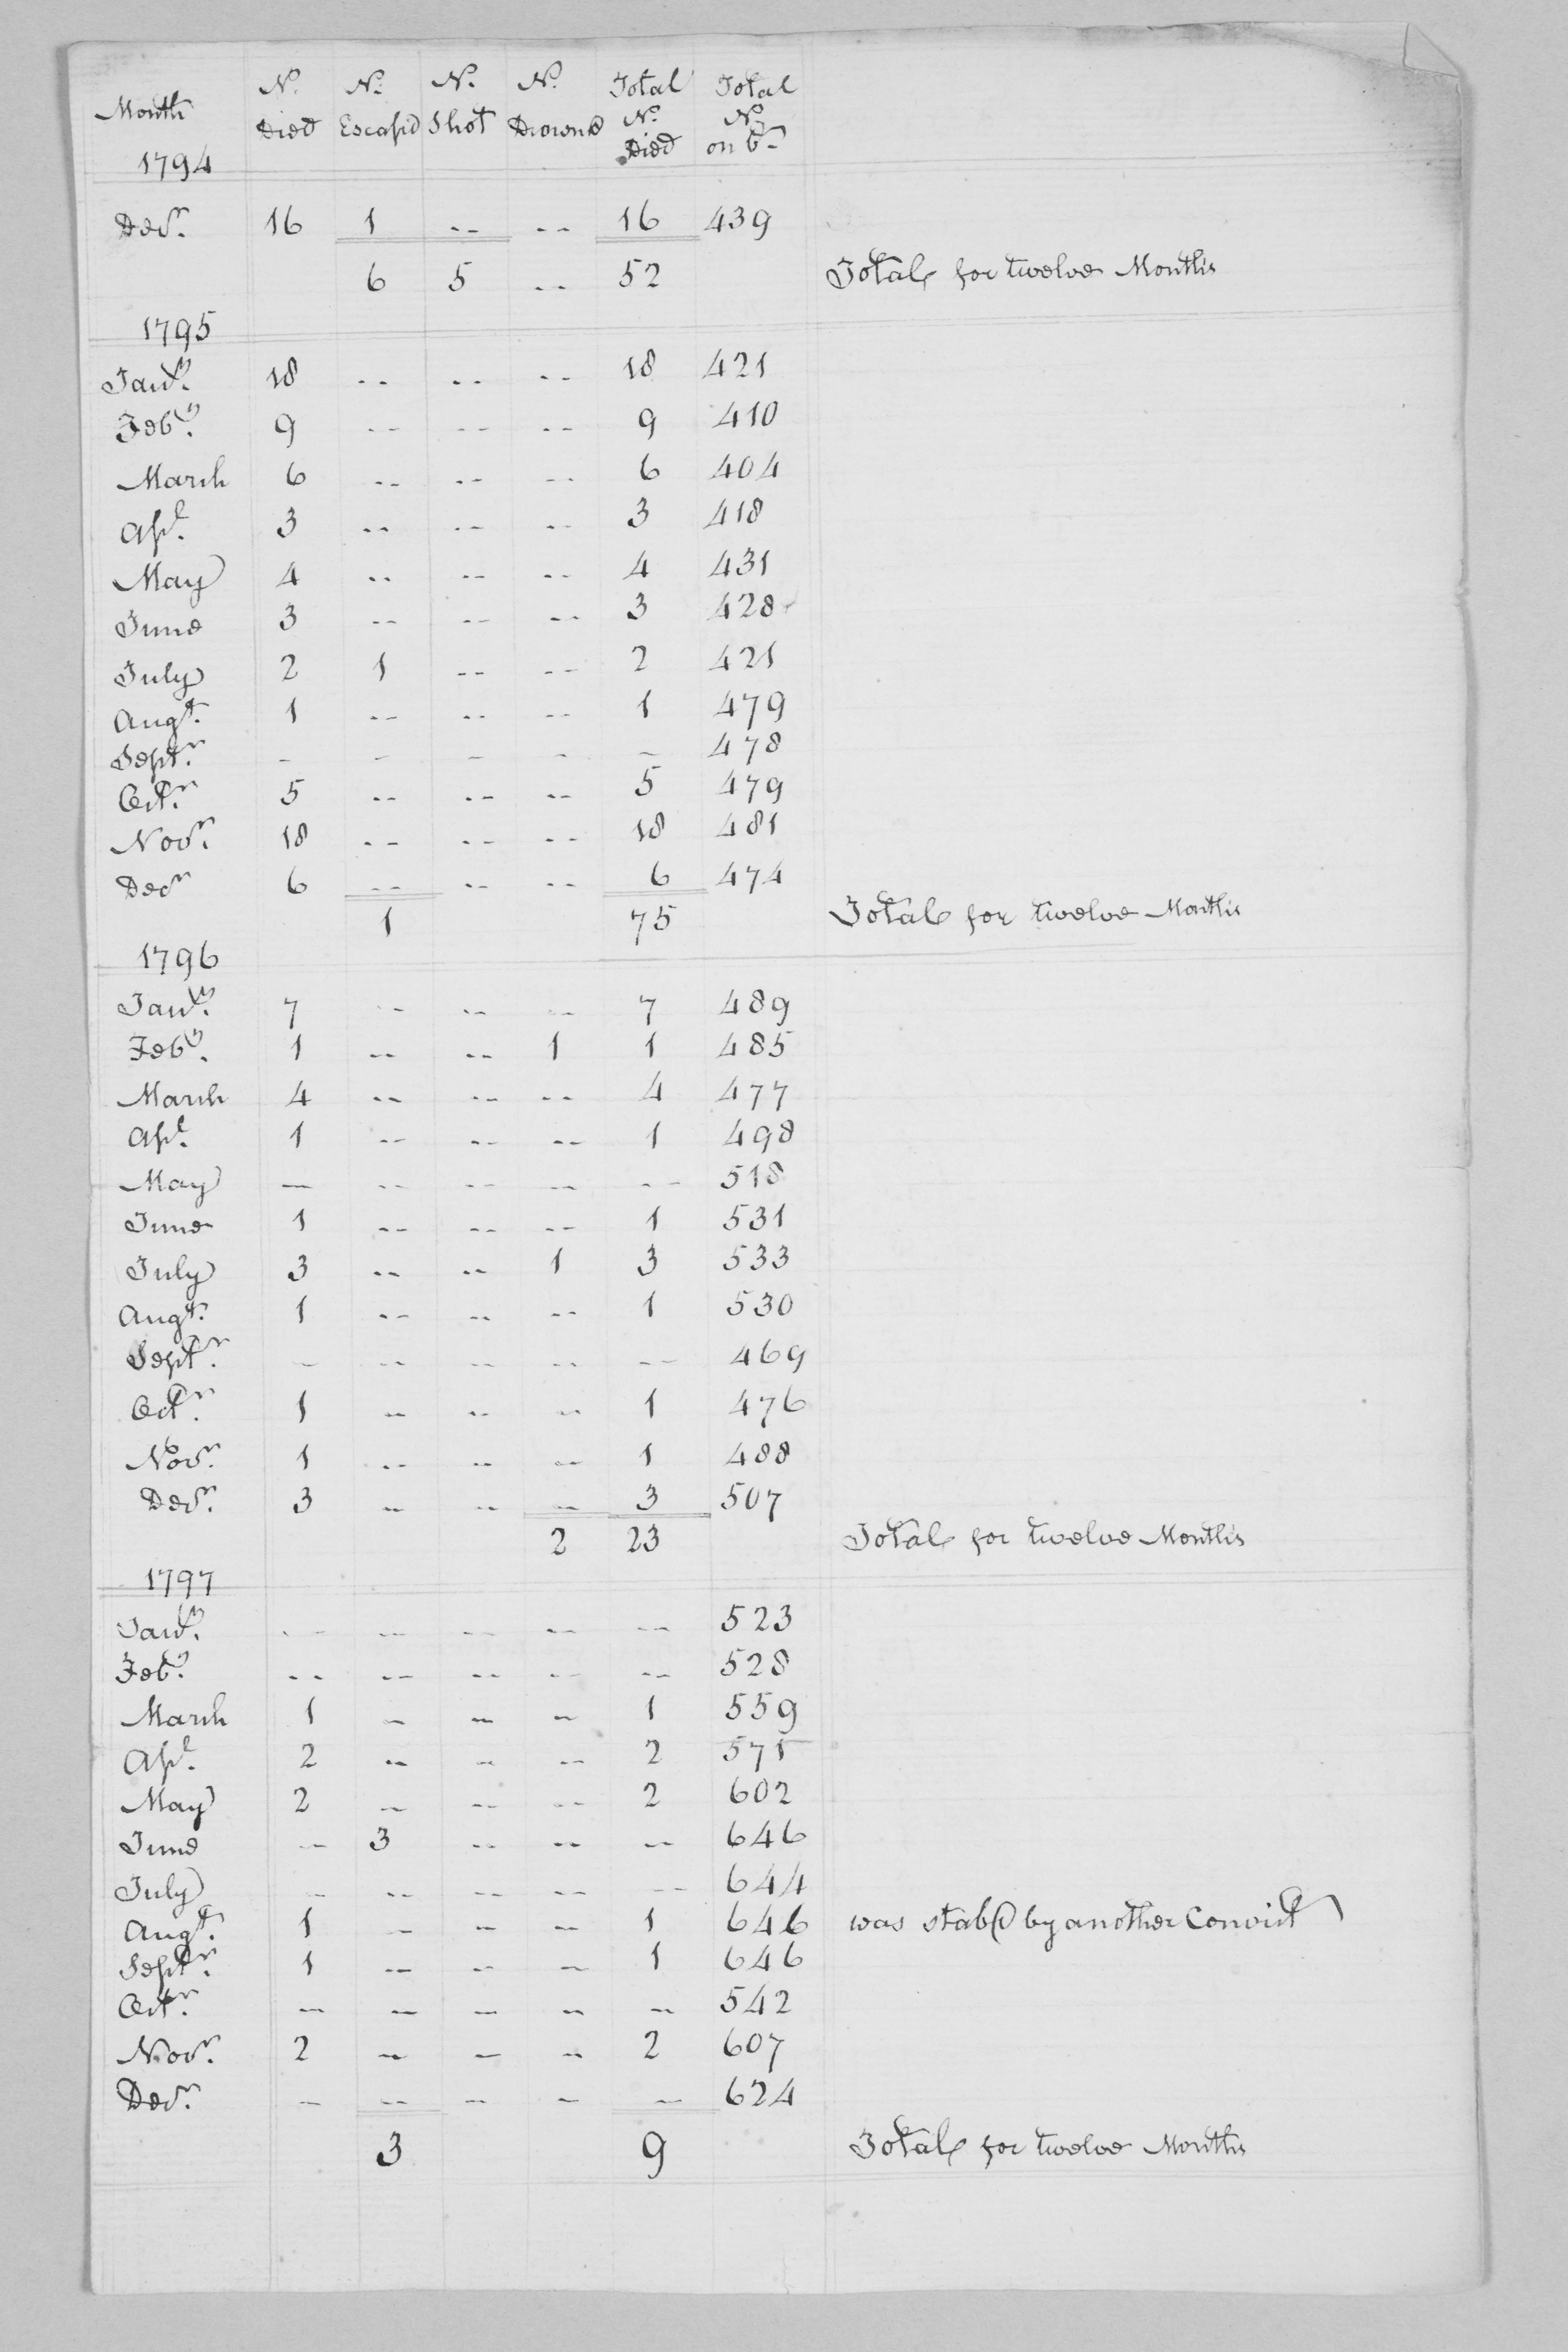

In [ ]:
image_df_2 = spark.read.format("binaryFile").load(imagePath_2)#.limit(1)

display_images(BinaryToImage().transform(image_df_2), "image")

In [ ]:
img_to_hocr_handwritten = ImageToTextV2().pretrained("ocr_small_handwritten", "en", "clinical/ocr") \
    .setInputCols(["image", "text_regions"]) \
    .setUsePandasUdf(False) \
    .setOutputFormat(OcrOutputFormat.HOCR) \
    .setOutputCol("hocr") \
    .setGroupImages(False)

pipeline_2 = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    text_detector,
    draw_regions,
    img_to_hocr_handwritten,
    hocr_to_table
])

result_2 = pipeline.transform(image_df_2).cache()
display(result_2)

ocr_small_handwritten download started this may take some time.
Approximate size to download 139.9 MB


+--------------------+-------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+
|         table_image|pagenum| length|   modificationTime|               image|                path|       table_regions|        text_regions|  image_with_regions|                hocr|              tables|exception|table_index|
+--------------------+-------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+
|{file:/home/alexa...|      0|4786163|2019-03-28 01:06:30|{file:/home/alexa...|file:/home/alexan...|{0, 0, 140.0, 107...|[{0, 0, 979.1998,...|{file:/home/alexa...|<?xml version="1....|{{0, 0, 0.0, 0.0,...|     null|          0|
+--------------------+-------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+-----------+

In [ ]:
display_tables(result_2, table_col = "tables", table_index_col = "table_index")

Filename: cTDaR_t00192.jpg
Page:     0
Table:    0
9


col0                         col1  \
0                                NO NO. 49 TOTAL LOTAL TOTAL   
1                        MOVING                         None   
2                        MOVING     GST EXCORD SHOT SNOWABLE   
3                          1794                         None   
4                          9.99                           16   
5                         9.99                         16 52   
6                          1795                         None   
7                          CLAY                                
8                          CLAY                                
9                          3969                                
10                         3969                                
11                         MAXN                                
12                        MAXN                           A18   
13        CLAY 3969 MAXN OWNS                      1 431 428   
14                         OWNS                         None   
15  CLAY 3969 MAXN OWNS QSEM                     1 5 A 2 5 5   
16                         QSEM                            5   
17                         QSEM                                
18                        QSEM                                 
19                         1796                         None   
20                          JAW                         None   
21                     JAW JAGE                                
22                         JAGE                                
23                         MANH                         None   
24                MANH MORY ONE                            1   
25  JAW MANH MORY JAGE ONE JENS                            1   
26                         MORY                         None   
27                         JENS                                
28                        JENS                             :   
29                      JENS                     5.30 4 69 4   
30                         VISA                                
31                     VISA QSP                            1   
32                     VISA QSP                            1   
33                         QSP                            1    
34                         1797                         None   
35                        JANED                                
36                        JANED                                
37                         3.60                                
38                         3.60                                
39                        THANK                                
40                    QTY THANK                            :   
41                    QTY THANK                            :   
42                    QTY THANK                            :   
43                        QTY                      : 602 64L   
44                        JULTY                                
45                      JULTY F                                
46                      JULTY F                                
47                JULTY QTY @ F                                
48                        QTY @                                
49                        QTY @                                
50               QTY @ KOOL: F                           1 1   
51                        KOOL:                                
52                        KOOL:                                
53                          QPM                                
54                          QPM                                

                        col2  col3  \
0                                    
1                       None  None   
2                       None  None   
3                       None  None   
4                               16   
5                              16    
6                       None  None   
7                                    
8                                    
9                                    
10                      